Note download data from https://drive.google.com/drive/folders/1EgDN57LDuvlZAwr5-eHWB5CTJ7K9HpDP

Credit to this repo: https://github.com/LukasMosser/geolink_dataset

## Data Disclaimer

All the data serving as an input to these notebooks was generously donated by GEOLINK  
and is CC-by-SA 4.0 

If you use their data please reference their dataset properly to give them credit for their contribution.

In [37]:
%reload_ext autoreload
%autoreload 2

In [38]:
import lasio
import matplotlib.pyplot as plt
%matplotlib inline
import os
from tqdm.auto import tqdm
import pandas as pd
import geopandas as gpd
import numpy as np
from pathlib import Path
from sklearn import preprocessing
from operator import itemgetter

# in and our directories

In [39]:
data_locations = Path(
    "../../data/raw/geolink_dataset/GEOLINK North sea wells with Lithology interpretation/GEOLINK_Lithology and wells NORTH SEA"
)
data_locations_wellheads = Path("../../data/raw/geolink_dataset/norge_well_heads")
interim_locations = Path("../../data/processed/geolink_norge_dataset/")
interim_locations2 = Path("../../data/interim/geolink_norge_dataset/")

# load and save as parquet

In [40]:
df_lithology = pd.read_excel(data_locations / "../Lithology code data.xlsx", header=1)[
    :-1
]
df_lithology["Abbreviation"] = pd.to_numeric(df_lithology["Abbreviation"])
df_lithology.to_parquet(
    interim_locations / "geolink_norge_lithology.parquet", compression="gzip"
)
df_lithology

,Lithology,Color,Lithology Attribute,Abbreviation
0,Aeolian Sandstone,LightYellow,CrossBedded Sand,35
1,Anhydrite,Light Magenta,Anhydrite,22
2,Argillaceous Limestone,Dodger Blue,Chalk,12
3,Arkose,LightGoldenrod,Gravel,36
4,Basement,Salmon,Intrusive,23
5,Biogenic Ooze,DarkYellow,Sandy Shale,25
6,Calcareous Cement,Cyan,Sandy Limestone,16
7,Calcareous Debris Flow,Turquoise,Breccia,31
8,Calcareous Shale,DarkCyan,Calcareous Shale,14
9,Carnallite,Magenta,Halite,33


In [41]:
# TODO rename well heads
df_well_tops = pd.concat(
    [
        pd.read_csv(data_locations_wellheads / "wellbore_exploration_all.csv"),
        pd.read_csv(data_locations_wellheads / "wellbore_development_all.csv"),
        pd.read_csv(data_locations_wellheads / "wellbore_other_all.csv"),
    ]
)
df_well_tops["wlbWellboreName_geolink"] = df_well_tops["wlbWellboreName"].str.replace(
    "/", "_"
)


# add dates
date_cols = ["wlbEntryDate", "wlbCompletionDate"]
for c in date_cols:
    df_well_tops[c] = pd.to_datetime(df_well_tops[c])  # .astype('str')

df_well_tops["wlbNsDecDeg"] = df_well_tops["wlbNsDecDeg"].replace(0, np.nan)
df_well_tops["wlbEwDesDeg"] = df_well_tops["wlbEwDesDeg"].replace(0, np.nan)

a = set(df_well_tops.columns)
df_well_tops = df_well_tops.dropna(axis=1, thresh=0.9 * len(df_well_tops))
b = set(df_well_tops.columns)
print("removed", a - b)

# make into geodataframe
df_well_tops = gpd.GeoDataFrame(
    df_well_tops,
    geometry=gpd.points_from_xy(df_well_tops.wlbEwDesDeg, df_well_tops.wlbNsDecDeg),
)
df_well_tops

removed {'wlbNpdidWellboreReclass', 'wlbField', 'fclNpdidFacilityDrilling', 'wlbPluggedDate', 'wlbPlotSymbol', 'wlbProductionFacility', 'wlbDiskosWellboreType', 'wlbNamePart5', 'wlbDiskosWellboreParent', 'wlbPluggedAbandonDate', 'wlbAgeWithHc1', 'wlbFormationWithHc2', 'fclNpdidFacilityProducing', 'wlbSeismicLocation', 'wlbReclassFromWellbore', 'prlNpdidProdLicenceTarget', 'wlbReleasedDate', 'wlbDiscovery', 'wlbLicensingActivity', 'wlbWdssQcDate', 'wlbNamePart6', 'wlbFactMapUrl', 'wlbContentPlanned', 'wlbFacilityTypeDrilling', 'wlbDrillingFacilityFixedOrMoveable', 'wlbStatus', 'wlbLicenceTargetName', 'wlbKickOffPoint', 'wlbAgeAtTd', 'wlbEntryPreDrillDate', 'dscNpdidDiscovery', 'wlbAgeWithHc3', 'wlbNpdidSiteSurvey', 'wlbPressReleaseUrl', 'wlbDateReclass', 'wlbFormationWithHc3', 'wlbDateUpdatedMax', 'wlbFinalVerticalDepth', 'prlNpdidProductionLicence', 'wlbBottomHoleTemperature', 'wlbFormationAtTd', 'wlbMultilateral', 'wlbContent', 'fldNpdidField', 'wlbAgeWithHc2', 'wlbCompPreDrillDate', 

,wlbWellboreName,wlbWell,wlbDrillingOperator,wlbProductionLicence,wlbPurpose,wlbWellType,wlbEntryDate,wlbCompletionDate,wlbDrillPermit,wlbKellyBushElevation,...,wlbNamePart1,wlbNamePart2,wlbNamePart3,wlbNamePart4,wlbFactPageUrl,wlbNpdidWellbore,wlbDateUpdated,datesyncNPD,wlbWellboreName_geolink,geometry
0,1/2-1,1/2-1,Phillips Petroleum Norsk AS,143,WILDCAT,EXPLORATION,1989-03-20,1989-04-06,604-L,22.0,...,1,2,,1,https://factpages.npd.no/factpages/default.asp...,1382,03.10.2019,03.07.2020,1_2-1,POINT (2.47658 56.88752)
1,1/2-2,1/2-2,Paladin Resources Norge AS,143 CS,WILDCAT,EXPLORATION,2005-12-14,2006-02-02,1103-L,40.0,...,1,2,,2,https://factpages.npd.no/factpages/default.asp...,5192,03.10.2019,03.07.2020,1_2-2,POINT (2.49657 56.99222)
2,1/3-1,1/3-1,A/S Norske Shell,011,WILDCAT,EXPLORATION,1968-06-07,1968-11-11,15-L,26.0,...,1,3,,1,https://factpages.npd.no/factpages/default.asp...,154,03.10.2019,03.07.2020,1_3-1,POINT (2.85139 56.85583)
3,1/3-2,1/3-2,A/S Norske Shell,011,WILDCAT,EXPLORATION,1969-05-14,1969-07-27,26-L,26.0,...,1,3,,2,https://factpages.npd.no/factpages/default.asp...,165,03.10.2019,03.07.2020,1_3-2,POINT (2.75000 56.93611)
4,1/3-3,1/3-3,Elf Petroleum Norge AS,065,WILDCAT,EXPLORATION,1982-08-22,1983-03-24,343-L,25.0,...,1,3,,3,https://factpages.npd.no/factpages/default.asp...,87,06.03.2020,03.07.2020,1_3-3,POINT (2.98168 56.95238)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1114,8006/8-U-4,8006/8-U-4,OCEAN DRILLING PROGRAM TEXAS A & M UNIVERSITY,NaN,SCIENTIFIC,OTHER,1993-08-29,1993-08-30,320-GJ,0.0,...,8006,8,U,4,https://factpages.npd.no/factpages/default.asp...,2234,03.10.2019,03.07.2020,8006_8-U-4,POINT (6.59040 80.26470)
1115,8008/7-U-1,8008/7-U-1,OCEAN DRILLING PROGRAM TEXAS A & M UNIVERSITY,NaN,SCIENTIFIC,OTHER,1993-08-22,1993-08-24,320-GK,0.0,...,8008,7,U,1,https://factpages.npd.no/factpages/default.asp...,2235,03.10.2019,03.07.2020,8008_7-U-1,POINT (8.22730 80.47440)
1116,8008/7-U-2,8008/7-U-2,OCEAN DRILLING PROGRAM TEXAS A & M UNIVERSITY,NaN,SCIENTIFIC,OTHER,1993-08-22,1993-08-24,320-GL,0.0,...,8008,7,U,2,https://factpages.npd.no/factpages/default.asp...,2236,03.10.2019,03.07.2020,8008_7-U-2,POINT (8.22730 80.47460)
1117,8008/7-U-3,8008/7-U-3,OCEAN DRILLING PROGRAM TEXAS A & M UNIVERSITY,NaN,SCIENTIFIC,OTHER,1993-08-22,1993-08-24,320-GM,0.0,...,8008,7,U,3,https://factpages.npd.no/factpages/default.asp...,2237,03.10.2019,03.07.2020,8008_7-U-3,POINT (8.22730 80.47480)


## Las files

We can now proceed to import these files as las files and get their dataframes and hopefully put them into a data format that is more suited for ML tasks.

In [43]:
if not (interim_locations2 / "geolink_norge_well_logs_raw.parquet").exists():

    # load las files
    well_dataframes = []
    files = sorted(data_locations.glob("*.las"))
    for f in tqdm(files):
        df = lasio.read(f).df()
        df["Well"] = f.stem
        well_dataframes.append(df)

    df_all = pd.concat(well_dataframes)

    df_all["Well"] = df_all["Well"].astype("category")

    # Name lithology
    litho_dict = df_lithology.set_index("Abbreviation")["Lithology"].to_dict()
    df_all["LITHOLOGY_GEOLINK"] = (
        df_all["LITHOLOGY_GEOLINK"].replace(litho_dict).astype("category")
    )

    # unique index
    df_all = df_all.reset_index()  # .set_index(['Well', 'DEPT'])

    df_all.to_parquet(
        interim_locations2 / "geolink_norge_well_logs_raw.parquet", compression="gzip"
    )

df_all = pd.read_parquet(interim_locations2 / "geolink_norge_well_logs_raw.parquet")
df_all

KeyboardInterrupt: 

## Clean las files

In [ ]:
# Clean.

# must have well head
df_all_clean2 = df_all[
    df_all.Well.apply(lambda s: s in set(df_well_tops["wlbWellboreName_geolink"]))
]

# must have lithology
df_all_clean2 = df_all_clean2.dropna(subset=["LITHOLOGY_GEOLINK"])
print("nans", df_all_clean2.isna().mean().sort_values())
# Keep /cols logs that are present>thresh of the time
df_all_clean1 = df_all_clean2.dropna(axis=1, thresh=0.6 * len(df_all_clean2))
print('kept {:%} cols'.format(len(df_all_clean1.columns) / len(df_all_clean2.columns)))
# print("nans", df_all_clean1.isna().mean().sort_values())

# Drop rows with any Nan's
df_all_clean = df_all_clean1.dropna(axis=0, how='any')
print('kept {:%} rows'.format(len(df_all_clean) / len(df_all_clean2)))
df_all_clean

In [ ]:
df_all_clean.dropna().Well.value_counts()

In [ ]:
df_all_clean[df_all_clean['LITHOLOGY_GEOLINK']=='Marlstone'].Well.value_counts()

In [ ]:
# 15_9-12

In [ ]:
from deep_ml_curriculum.visualization.well_log import plot_facies, plot_well
well_name="30_4-1"
logs = df_all_clean[df_all_clean2.Well==well_name]
facies = logs['LITHOLOGY_GEOLINK'].astype('category').values
plot_well(well_name, 
          logs, 
          facies)

In [ ]:
from deep_ml_curriculum.visualization.well_log import plot_facies, plot_well
well_name="30_6-11"
logs = df_all_clean[df_all_clean2.Well==well_name]
facies = logs['LITHOLOGY_GEOLINK'].astype('category').values
plot_well(well_name, 
          logs, 
          facies)

In [ ]:
# Split by well name
# wells_val = [
#     "35_11-1",
#     "35_11-10",
#     "35_11-11",
#     "35_11-12",
#     "35_11-13",
#     "35_11-15 S",
#     "35_11-2",
#     "35_11-5",
#     "35_11-6",
#     "35_11-7",
#     "35_12-1",
# ]

wells_test = [
    "34_10-12",
    "34_10-16 R",
    "34_10-17",
    "34_10-19",
    "34_10-21",
    "34_10-23",
    "34_10-33",
    "34_10-35",
    "34_10-5",
    "34_10-7",
    "34_11-1",
    "34_11-2 S",
    "34_11-3 T2",
]

In [ ]:
df_all_clean_test = df_all_clean[df_all_clean.Well.apply(lambda s: s in wells_test)]
df_all_clean_train = df_all_clean[
    df_all_clean.Well.apply(lambda s: (s not in wells_test))
]
# assert len(set(df_all_clean_val.Well).intersection(set(df_all_clean_train))) == 0
assert len(set(df_all_clean_test.Well).intersection(set(df_all_clean_train))) == 0
# assert len(set(df_all_clean_test.Well).intersection(set(df_all_clean_val))) == 0
len(df_all_clean_train), len(df_all_clean_test)

In [ ]:
df_all_clean_train.to_parquet(
    interim_locations / "geolink_norge_well_logs_train.parquet", compression="gzip"
)
df_all_clean_test.to_parquet(
    interim_locations / "geolink_norge_well_logs_test.parquet", compression="gzip"
)
# df_all_clean_val.to_parquet(
#     interim_locations / "geolink_norge_well_logs_val.parquet", compression="gzip"
# )

In [ ]:
df_all_clean

# Others

In [ ]:
df_picks = pd.read_excel(
    data_locations / "../NPD stratigraphic picks north sea.xlsx", header=0
)
df_picks.to_parquet(
    interim_locations / "geolink_norge_picks.parquet", compression="gzip"
)

In [ ]:
df_picks

## Well heads part 2

In [ ]:
# only wells we use
a = sorted(df_all.Well.unique())
df_well_tops = df_well_tops[
    df_well_tops["wlbWellboreName_geolink"].apply(lambda s: s in a)
]

In [ ]:
df_well_tops.to_file(interim_locations / "norge_well_tops.gpkg", driver="GPKG")

# Example Load

In [ ]:
# Test load
df_all_clean2 = pd.read_parquet(
    interim_locations / "geolink_norge_well_logs_train.parquet"
)  # .set_index(['Well', 'DEPT'])

df_well_tops = gpd.read_file(interim_locations / "norge_well_tops.gpkg")
df_well_tops_minimal = df_well_tops[
    [
        "wlbWellboreName_geolink",
        "wlbCompletionYear",
        "wlbKellyBushElevation",
        "wlbCompletionDate",
        "wlbTotalDepth",
        "geometry",
    ]
]
df_well_tops.plot()

In [ ]:
# Merge well tops and well logs, a selection
df_all_clean3 = pd.merge(
    left=df_all_clean2.sample(1000),
    right=df_well_tops_minimal,
    left_on="Well",
    right_on="wlbWellboreName_geolink",
    how="left",
).drop(columns="wlbWellboreName_geolink")
df_all_clean3 = df_all_clean3.set_index(['Well', 'DEPT'])
df_all_clean3 = gpd.GeoDataFrame(df_all_clean3, geometry=df_all_clean3['geometry'])
df_all_clean3.plot()
# df_all_clean3

In [ ]:
df_picks = pd.read_parquet(interim_locations / "geolink_norge_picks.parquet")
df_picks

In [ ]:
df_all_clean = pd.read_parquet(
    interim_locations / "geolink_norge_well_logs_train.parquet"
).set_index(["Well", "DEPT"])
df_all_clean

# Example plot

In [ ]:
df_all_clean = pd.read_parquet(
    interim_locations / "geolink_norge_well_logs_train.parquet"
).set_index(["Well", "DEPT"])
df_all_clean['DEPT'] = df_all_clean.index.get_level_values(1)
df_all_clean

In [ ]:
# logs

In [ ]:
from deep_ml_curriculum.visualization.well_log import plot_facies, plot_well
well_name="30_4-1"
logs = df_all_clean.xs(well_name)
facies = logs['LITHOLOGY_GEOLINK'].astype('category').values
plot_well(well_name, 
          logs, 
          facies)

In [ ]:
plt.figure(figsize=(1,8))
plot_facies(facies, plt.gca(), colorbar=False)

# reindex depth and to Xarray

This lets us includes location easily without using much more space

In [44]:
# Load some
df_all_clean1 = pd.read_parquet(
    interim_locations / "geolink_norge_well_logs_test.parquet"
).set_index(['Well', 'DEPT'])
df_all_clean1['Depth'] = df_all_clean1.index.get_level_values(1)
df_all_clean1['split'] = 'test'

# Load some
df_all_clean2 = pd.read_parquet(
    interim_locations / "geolink_norge_well_logs_train.parquet"
).set_index(['Well', 'DEPT'])
df_all_clean2['Depth'] = df_all_clean2.index.get_level_values(1)
df_all_clean2['split'] = 'train'

# # Load some
# df_all_clean3 = pd.read_parquet(
#     interim_locations / "geolink_norge_well_logs_val.parquet"
# ).set_index(['Well', 'DEPT'])
# df_all_clean3['Depth'] = df_all_clean3.index.get_level_values(1)
# df_all_clean3['split'] = 'val'

df_all = pd.concat([df_all_clean1, df_all_clean2])
df_all

LITHOLOGY_GEOLINK    CALI      DRHO     NPHI      RHOB  \
Well     DEPT                                                                 
34_10-12 1930.174316         Marlstone  12.977 -0.012000  0.48633  2.168000   
         1930.326660         Marlstone  13.273 -0.019000  0.44824  2.150000   
         1930.479126         Marlstone  13.570 -0.028000  0.40479  2.137000   
         1930.631470         Marlstone  14.016 -0.026000  0.39746  2.139000   
         1930.783813         Marlstone  13.883 -0.017000  0.40332  2.143000   
...                                ...     ...       ...      ...       ...   
7_3-1    2723.585938         Anhydrite   9.157  0.141856  0.00000  2.692753   
         2723.738525         Anhydrite   9.197  0.148906  0.00000  2.695477   
         2723.890869         Anhydrite   9.236  0.148817  0.00000  2.701625   
         2724.043213         Anhydrite   9.262  0.150856  0.00000  2.702774   
         2724.195557         Anhydrite   9.268  0.145638  0.00000  2.690725   

                             GR         DTC         RDEP         SP  \
Well     DEPT                                                         
34_10-12 1930.174316  39.741283  131.493591     0.900000  65.886795   
         1930.326660  37.034103  129.506012     0.894000  65.514198   
         1930.479126  38.006210  131.366592     0.894000  65.889206   
         1930.631470  39.944405  128.745590     0.896000  66.264603   
         1930.783813  41.935070  127.375900     0.900000  66.763603   
...                         ...         ...          ...        ...   
7_3-1    2723.585938  15.846580   53.005497  1504.687866  59.057552   
         2723.738525  16.209375   53.386738  1514.930054  58.484932   
         2723.890869  16.638577   53.277893  1522.655029  58.483002   
         2724.043213  16.997316   52.928886  1530.355835  58.843422   
         2724.195557  17.194046   52.892044  1538.068726  59.203846   

                           RSHA         RMED        Depth  split  
Well     DEPT                                                     
34_10-12 1930.174316   0.893119     0.893119  1930.174316   test  
         1930.326660   0.930102     0.930102  1930.326660   test  
         1930.479126   0.962067     0.962067  1930.479126   test  
         1930.631470   0.983128     0.983128  1930.631470   test  
         1930.783813   1.022998     1.022998  1930.783813   test  
...                         ...          ...          ...    ...  
7_3-1    2723.585938  14.382000  1453.242920  2723.585938  train  
         2723.738525  14.387000  1471.283691  2723.738525  train  
         2723.890869  14.390000  1473.072998  2723.890869  train  
         2724.043213  14.390000  1473.072998  2724.043213  train  
         2724.195557  14.389000  1473.072998  2724.195557  train  

[744584 rows x 13 columns]

In [45]:
df_well_tops = gpd.read_file(interim_locations / "norge_well_tops.gpkg")
df_well_tops_minimal = df_well_tops[
    [
        "wlbWellboreName_geolink",
        "wlbCompletionYear",
        "wlbKellyBushElevation",
        "wlbCompletionDate",
        "wlbTotalDepth",
        "geometry",
    ]
].copy()
df_well_tops_minimal['xc'] = df_well_tops_minimal.geometry.x
df_well_tops_minimal['yc'] = df_well_tops_minimal.geometry.y
df_well_tops_minimal

,wlbWellboreName_geolink,wlbCompletionYear,wlbKellyBushElevation,wlbCompletionDate,wlbTotalDepth,geometry,xc,yc
0,6_3-1,1985,23.0,1985-01-02T00:00:00,3560.0,POINT (1.92511 57.96950),1.925106,57.969500
1,6_3-2,1986,22.0,1986-10-03T00:00:00,4091.0,POINT (1.98727 57.90722),1.987275,57.907219
2,7_1-1,1971,34.0,1971-05-08T00:00:00,2808.0,POINT (2.16556 57.79778),2.165556,57.797778
3,7_1-2 S,2008,44.0,2008-08-05T00:00:00,3175.0,POINT (2.06967 57.93252),2.069672,57.932525
4,7_3-1,1969,31.0,1969-10-06T00:00:00,4700.0,POINT (2.74878 57.84313),2.748781,57.843125
5,15_9-2,1978,25.0,1978-06-17T00:00:00,3764.0,POINT (1.70783 58.42613),1.707833,58.426128
6,15_9-4,1979,25.0,1979-06-14T00:00:00,3716.0,POINT (1.78526 58.40007),1.785258,58.400072
7,15_9-5,1980,25.0,1980-11-04T00:00:00,3946.0,POINT (1.70811 58.40346),1.708111,58.403464
8,15_9-7,1981,25.0,1981-04-29T00:00:00,3776.0,POINT (1.71277 58.38224),1.712775,58.382242
9,15_9-8,1981,25.0,1981-05-25T00:00:00,3730.0,POINT (1.77453 58.38217),1.774533,58.382169


In [46]:
nidx = np.arange(400, 5500, 0.15)

In [47]:
def reindex(x):
    """Reindex each well to 15cm"""
    if len(x)==0: return None
    x = x.reset_index().set_index('DEPT')
    x = x.reindex(nidx, method='nearest', limit=1).drop(columns=['Well']).sort_index()
    return x
#     return x.reset_index().set_index(['Well', 'DEPT'])

df_all3 = df_all.groupby(level=0).apply(reindex).dropna()
df_all3

LITHOLOGY_GEOLINK       CALI      DRHO      NPHI      RHOB  \
Well    DEPT                                                                 
15_9-12 2215.90        Shaly Silt  14.438001  0.010000  0.447725  2.363000   
        2216.05        Shaly Silt  14.633000  0.006000  0.432095  2.340000   
        2216.20        Shaly Silt  14.813001  0.006000  0.410166  2.314000   
        2216.35        Shaly Silt  14.383001 -0.001000  0.414143  2.293000   
        2216.50        Shaly Silt  14.202999  0.001000  0.439923  2.275000   
...                           ...        ...       ...       ...       ...   
7_3-1   2723.65         Anhydrite   9.157000  0.141856  0.000000  2.692753   
        2723.80         Anhydrite   9.197000  0.148906  0.000000  2.695477   
        2723.95         Anhydrite   9.236000  0.148817  0.000000  2.701625   
        2724.10         Anhydrite   9.262000  0.150856  0.000000  2.702774   
        2724.25         Anhydrite   9.268000  0.145638  0.000000  2.690725   

                        GR         DTC         RDEP         SP       RSHA  \
Well    DEPT                                                                
15_9-12 2215.90  60.285748  134.253601     0.737006  50.570400   0.785088   
        2216.05  63.250000  129.101868     0.741000  50.820000   0.840000   
        2216.20  61.405998  122.476944     0.752000  50.820000   0.858000   
        2216.35  62.561596  116.908607     0.739962  51.070000   0.857046   
        2216.50  61.691055  115.390953     0.715966  51.070602   0.886082   
...                    ...         ...          ...        ...        ...   
7_3-1   2723.65  15.846580   53.005497  1504.687866  59.057552  14.382000   
        2723.80  16.209375   53.386738  1514.930054  58.484932  14.387000   
        2723.95  16.638577   53.277893  1522.655029  58.483002  14.390000   
        2724.10  16.997316   52.928886  1530.355835  58.843422  14.390000   
        2724.25  17.194046   52.892044  1538.068726  59.203846  14.389000   

                        RMED        Depth  split  
Well    DEPT                                      
15_9-12 2215.90     0.785088  2215.917725  train  
        2216.05     0.840000  2216.070068  train  
        2216.20     0.858000  2216.222412  train  
        2216.35     0.857046  2216.375000  train  
        2216.50     0.886082  2216.527344  train  
...                      ...          ...    ...  
7_3-1   2723.65  1453.242920  2723.585938  train  
        2723.80  1471.283691  2723.738525  train  
        2723.95  1473.072998  2723.890869  train  
        2724.10  1473.072998  2724.043213  train  
        2724.25  1473.072998  2724.195557  train  

[725981 rows x 13 columns]

In [48]:
import xarray as xr
xr_all_clean2 = df_all3.to_xarray()
xr_all_clean2

<xarray.Dataset>
Dimensions:            (DEPT: 33472, Well: 118)
Coordinates:
  * Well               (Well) object '15_9-12' '15_9-13' ... '7_1-1' '7_3-1'
  * DEPT               (DEPT) float64 414.7 414.8 415.0 ... 5.435e+03 5.435e+03
Data variables:
    LITHOLOGY_GEOLINK  (Well, DEPT) object nan nan nan nan ... nan nan nan nan
    CALI               (Well, DEPT) float64 nan nan nan nan ... nan nan nan nan
    DRHO               (Well, DEPT) float64 nan nan nan nan ... nan nan nan nan
    NPHI               (Well, DEPT) float64 nan nan nan nan ... nan nan nan nan
    RHOB               (Well, DEPT) float64 nan nan nan nan ... nan nan nan nan
    GR                 (Well, DEPT) float64 nan nan nan nan ... nan nan nan nan
    DTC                (Well, DEPT) float64 nan nan nan nan ... nan nan nan nan
    RDEP               (Well, DEPT) float64 nan nan nan nan ... nan nan nan nan
    SP                 (Well, DEPT) float64 nan nan nan nan ... nan nan nan nan
    RSHA               (Well, DEPT) float64 nan nan nan nan ... nan nan nan nan
    RMED               (Well, DEPT) float64 nan nan nan nan ... nan nan nan nan
    Depth              (Well, DEPT) float64 nan nan nan nan ... nan nan nan nan
    split              (Well, DEPT) object nan nan nan nan ... nan nan nan nan

In [49]:
xr_wells = df_well_tops_minimal.rename(columns={'wlbWellboreName_geolink':'Well'}).set_index('Well').to_xarray()
xr_wells

<xarray.Dataset>
Dimensions:                (Well: 221)
Coordinates:
  * Well                   (Well) object '6_3-1' '6_3-2' ... '36_7-1' '36_7-3'
Data variables:
    wlbCompletionYear      (Well) int64 1985 1986 1971 2008 ... 2011 1996 2002
    wlbKellyBushElevation  (Well) float64 23.0 22.0 34.0 44.0 ... 29.0 22.0 24.0
    wlbCompletionDate      (Well) object '1985-01-02T00:00:00' ... '2002-06-0...
    wlbTotalDepth          (Well) float64 3.56e+03 4.091e+03 ... 2.948e+03
    geometry               (Well) object POINT (1.925106 57.9695) ... POINT (...
    xc                     (Well) float64 1.925 1.987 2.166 ... 3.692 4.016 4.05
    yc                     (Well) float64 57.97 57.91 57.8 ... 61.19 61.35 61.43

In [50]:
xr_all = xr.merge(
    [xr_all_clean2, xr_wells],
    join='left')

In [51]:
xr_all2 = xr_all.sortby(['Well', 'DEPT'])
xr_all2

<xarray.Dataset>
Dimensions:                (DEPT: 33472, Well: 118)
Coordinates:
  * Well                   (Well) object '15_9-12' '15_9-13' ... '7_1-1' '7_3-1'
  * DEPT                   (DEPT) float64 414.7 414.8 ... 5.435e+03 5.435e+03
Data variables:
    LITHOLOGY_GEOLINK      (Well, DEPT) object nan nan nan nan ... nan nan nan
    CALI                   (Well, DEPT) float64 nan nan nan nan ... nan nan nan
    DRHO                   (Well, DEPT) float64 nan nan nan nan ... nan nan nan
    NPHI                   (Well, DEPT) float64 nan nan nan nan ... nan nan nan
    RHOB                   (Well, DEPT) float64 nan nan nan nan ... nan nan nan
    GR                     (Well, DEPT) float64 nan nan nan nan ... nan nan nan
    DTC                    (Well, DEPT) float64 nan nan nan nan ... nan nan nan
    RDEP                   (Well, DEPT) float64 nan nan nan nan ... nan nan nan
    SP                     (Well, DEPT) float64 nan nan nan nan ... nan nan nan
    RSHA                   (Well, DEPT) float64 nan nan nan nan ... nan nan nan
    RMED                   (Well, DEPT) float64 nan nan nan nan ... nan nan nan
    Depth                  (Well, DEPT) float64 nan nan nan nan ... nan nan nan
    split                  (Well, DEPT) object nan nan nan nan ... nan nan nan
    wlbCompletionYear      (Well) int64 1982 1982 1982 1982 ... 1986 1971 1969
    wlbKellyBushElevation  (Well) float64 25.0 25.0 25.0 25.0 ... 22.0 34.0 31.0
    wlbCompletionDate      (Well) object '1982-02-27T00:00:00' ... '1969-10-0...
    wlbTotalDepth          (Well) float64 3.74e+03 3.28e+03 ... 4.7e+03
    geometry               (Well) object POINT (1.717781 58.456436) ... POINT...
    xc                     (Well) float64 1.718 1.934 1.691 ... 2.166 2.749
    yc                     (Well) float64 58.46 58.37 58.29 ... 57.91 57.8 57.84

,Well,LITHOLOGY_GEOLINK,CALI,DRHO,NPHI,RHOB,GR,DTC,RDEP,SP,...,Depth,split,wlbCompletionYear,wlbKellyBushElevation,wlbCompletionDate,wlbTotalDepth,geometry,xc,yc,DEPT
DEPT,,,,,,,,,,,,,,,,,,,,,
1924.90,30_4-1,Silt,19.229000,-0.004000,0.407435,2.160033,43.573063,125.354637,1.271021,51.008926,...,1925.031860,train,1979,24.3,1979-05-14T00:00:00,5454.0,POINT (2.159614 60.622464),2.159614,60.622464,1925.031860
1925.05,30_4-1,Silt,19.229000,-0.004000,0.407435,2.160033,43.573063,125.354637,1.271021,51.008926,...,1925.031860,train,1979,24.3,1979-05-14T00:00:00,5454.0,POINT (2.159614 60.622464),2.159614,60.622464,1925.031860
1925.20,30_4-1,Cinerite,19.264000,0.001000,0.399621,2.157022,44.785027,123.796204,1.257022,52.834549,...,1925.184204,train,1979,24.3,1979-05-14T00:00:00,5454.0,POINT (2.159614 60.622464),2.159614,60.622464,1925.184204
1925.35,30_4-1,Cinerite,19.312000,0.003000,0.392289,2.160177,45.022621,122.600998,1.239043,53.518486,...,1925.336548,train,1979,24.3,1979-05-14T00:00:00,5454.0,POINT (2.159614 60.622464),2.159614,60.622464,1925.336548
1925.50,30_4-1,Cinerite,19.360001,0.004000,0.398116,2.163876,45.389706,122.731598,1.225022,54.125484,...,1925.489014,train,1979,24.3,1979-05-14T00:00:00,5454.0,POINT (2.159614 60.622464),2.159614,60.622464,1925.489014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2276.05,30_4-1,Silt,18.073999,0.047958,-0.055140,2.364307,48.278000,101.582390,1.683030,71.094002,...,2276.009033,train,1979,24.3,1979-05-14T00:00:00,5454.0,POINT (2.159614 60.622464),2.159614,60.622464,2276.009033
2276.20,30_4-1,Silt,18.000999,0.045010,-0.056777,2.347309,50.699120,103.808281,1.692984,72.750999,...,2276.161377,train,1979,24.3,1979-05-14T00:00:00,5454.0,POINT (2.159614 60.622464),2.159614,60.622464,2276.161377
2276.35,30_4-1,Silt,18.020000,0.025096,-0.058328,2.346604,51.971962,103.750862,1.701986,74.087997,...,2276.313721,train,1979,24.3,1979-05-14T00:00:00,5454.0,POINT (2.159614 60.622464),2.159614,60.622464,2276.313721


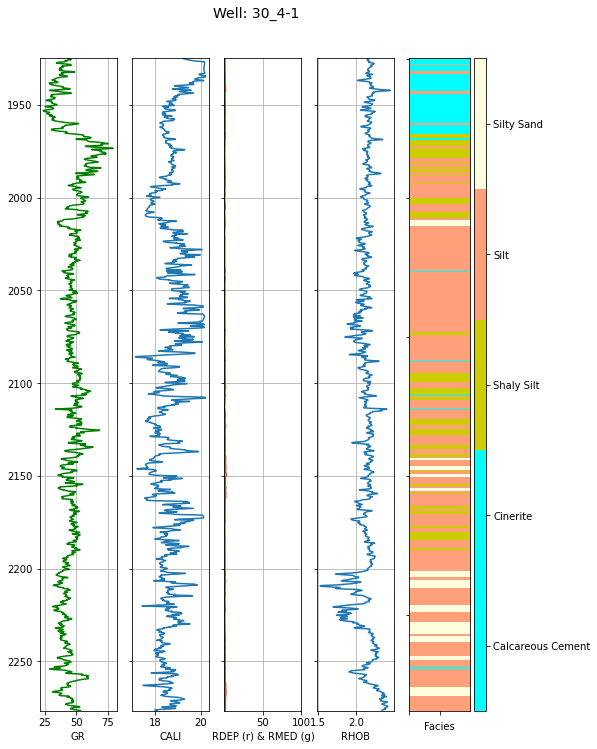

In [55]:
well_name="30_4-1"
logs = xr_all2.sel(Well=well_name).to_dataframe().dropna()
logs['DEPT'] = logs['Depth']
facies = logs['LITHOLOGY_GEOLINK'].astype('category').values
plot_well(well_name, logs, facies)
logs

,LITHOLOGY_GEOLINK,CALI,RHOB,GR,DTC,RDEP,RMED,DEPT
DEPT,,,,,,,,
1908.267822,Shaly Silt,20.122000,2.067214,75.447586,150.820175,0.873966,0.587002,1908.267822
1908.420166,Shaly Silt,20.029001,2.035628,82.692192,160.208496,0.886958,0.588001,1908.420166
1908.572510,Shaly Silt,19.850000,2.026366,89.060791,162.881058,0.896968,0.589002,1908.572510
1908.724976,Shaly Silt,19.641001,2.029380,95.180099,162.189087,0.904974,0.591002,1908.724976
1908.877319,Shaly Silt,19.454000,2.033669,99.270447,160.636047,0.912974,0.593001,1908.877319
...,...,...,...,...,...,...,...,...
5438.309082,Cross Bedded Sst,8.212000,2.531613,53.201000,81.876411,3.624000,4.091420,5438.309082
5438.461426,Cross Bedded Sst,8.215000,2.529216,48.216999,81.879501,3.895000,4.848202,5438.461426
5438.613769,Cross Bedded Sst,8.217000,2.527219,45.028000,82.356583,4.279000,6.158574,5438.613769


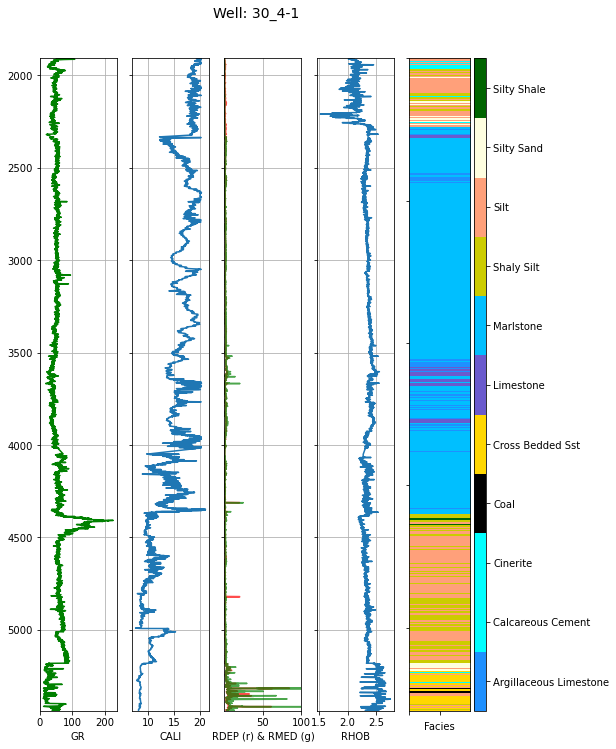

In [56]:
from deep_ml_curriculum.visualization.well_log import plot_facies, plot_well
well_name="30_4-1"
logs = df_all_clean.xs(well_name)
facies = logs['LITHOLOGY_GEOLINK'].astype('category').values
plot_well(well_name, 
          logs, 
          facies)
logs

In [59]:
def dset_to_nc(dset, f, engine="netcdf4", compression={"zlib": True}):
    if isinstance(dset, xr.DataArray):
        dset = dset.to_dataset(name="data")
    encoding = {k: {"zlib": True} for k in dset.data_vars}
    print('saving to {}'.format(f))
    dset.to_netcdf(f, engine=engine, encoding=encoding)
    print('Wrote {}.nc size={} M'.format(f.stem, f.stat().st_size / 1000000.0))
dset_to_nc(dset=xr_all.drop(['geometry']),
          f=interim_locations/'geolink_norge_well_logs.h5')

In [74]:
import os, shutil

def get_dir_size(start_path="."):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(start_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            total_size += os.path.getsize(fp)
    return total_size

def dset_to_zarr(dset, f):
    if isinstance(dset, xr.DataArray):
        dset = dset.to_dataset(name="data")
    encoding = {k: {"zlib": True} for k in dset.data_vars}
    print('saving to {}'.format(f))
    if f.exists():
        try:
            return xr.open_zarr(f)
        except:
            shutil.rmtree(f)
    dset.to_zarr(str(f))
    print('{}.zarr size={} M'.format(f.stem, get_dir_size(str(f)) / 1000000.0))
    
dset_to_zarr(dset=xr_all.drop(['geometry']),
          f=interim_locations/'geolink_norge_well_logs.zarr')

saving to ../../data/processed/geolink_norge_dataset/geolink_norge_well_logs.zarr
geolink_norge_well_logs.zarr size=49.057065 M


# Plot map

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import os
from tqdm.auto import tqdm
import pandas as pd
import geopandas as gpd
import numpy as np

In [ ]:
# import pandas as pd
# import xarray as xr
# xf = xr.open_zarr("../../data/processed/geolink_norge_dataset/geolink_norge_well_logs.zarr")
# df = xf.to_dataframe().swaplevel().sample(1000)
# df['LITHOLOGY_GEOLINK'] = df['LITHOLOGY_GEOLINK'].astype('category')
# df['Well'] = df.index.get_level_values(0).astype('category')
# df['DEPT'] = df.index.get_level_values(1)
# feature_cols = ['CALI', 'DTC', 'GR', 'RDEP', 'RHOB',
#        'RMED', 'xc', 'yc', 'DEPT']
# df = df.dropna(how='any', subset=feature_cols+['LITHOLOGY_GEOLINK'])
# df = df.sort_index()

# import geopandas as gpd
# gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.xc, df.yc))
# gdf = gdf.set_crs(epsg=4326).to_crs(epsg=3857)
# gdf.plot()

# Plot contextily

In [ ]:
from pathlib import Path
interim_locations = Path("../../data/processed/geolink_norge_dataset/")
df_well_tops = gpd.read_file(interim_locations / "norge_well_tops.gpkg").set_crs(epsg=4326).to_crs(epsg=3857)#.head(40)
# df_well_tops.plot()

In [ ]:


import contextily as ctx
ax = df_well_tops.plot(figsize=(18, 18), edgecolor='k')
ctx.add_basemap(ax, url=ctx.providers.Esri.OceanBasemap, zoom=8)

# Plot every 5th
df_well_tops[::5].apply(lambda x: 
                   ax.annotate(
                       s=x.wlbWellboreName, 
                       xy=x.geometry.centroid.coords[0], 
                       ha='left',
                       c='white',
                       
                   ), axis=1);

In [ ]:
ax = df_well_tops.plot(figsize=(18, 18), edgecolor='k')
# ctx.add_basemap(ax, url=ctx.providers.Esri.OceanBasemap)
ctx.add_basemap(ax,
                crs=df_well_tops.crs.to_string(),
                source=ctx.providers.Stamen.Watercolor
               )

# Plot every 5th
df_well_tops[::5].apply(lambda x: 
                   ax.annotate(
                       s=x.wlbWellboreName, 
                       xy=x.geometry.centroid.coords[0], 
                       ha='left',
                       c='white'
                   ), axis=1);


In [ ]:
west, south, east, north = bbox = df_well_tops.total_bounds
img, ext = ctx.bounds2raster(west,
                             south,
                             east,
                             north,
                             "world_watercolor.tif",
                             source=ctx.providers.Stamen.Watercolor,
                             ll=True,
                             zoom=8
                            )

In [ ]:
west, south, east, north = bbox = df_well_tops.total_bounds
img, ext = ctx.bounds2raster(west,
                             south,
                             east,
                             north,
                             "oceanesri.tif",
                             source=ctx.providers.Esri.OceanBasemap,
                             ll=True,
                             zoom=8
                            )

In [ ]:
ctx.bounds2raster?